# 고객 데이터를 활용한 상품 배송 분석

## 데이터 확인
피쳐 컬럼 리스트  
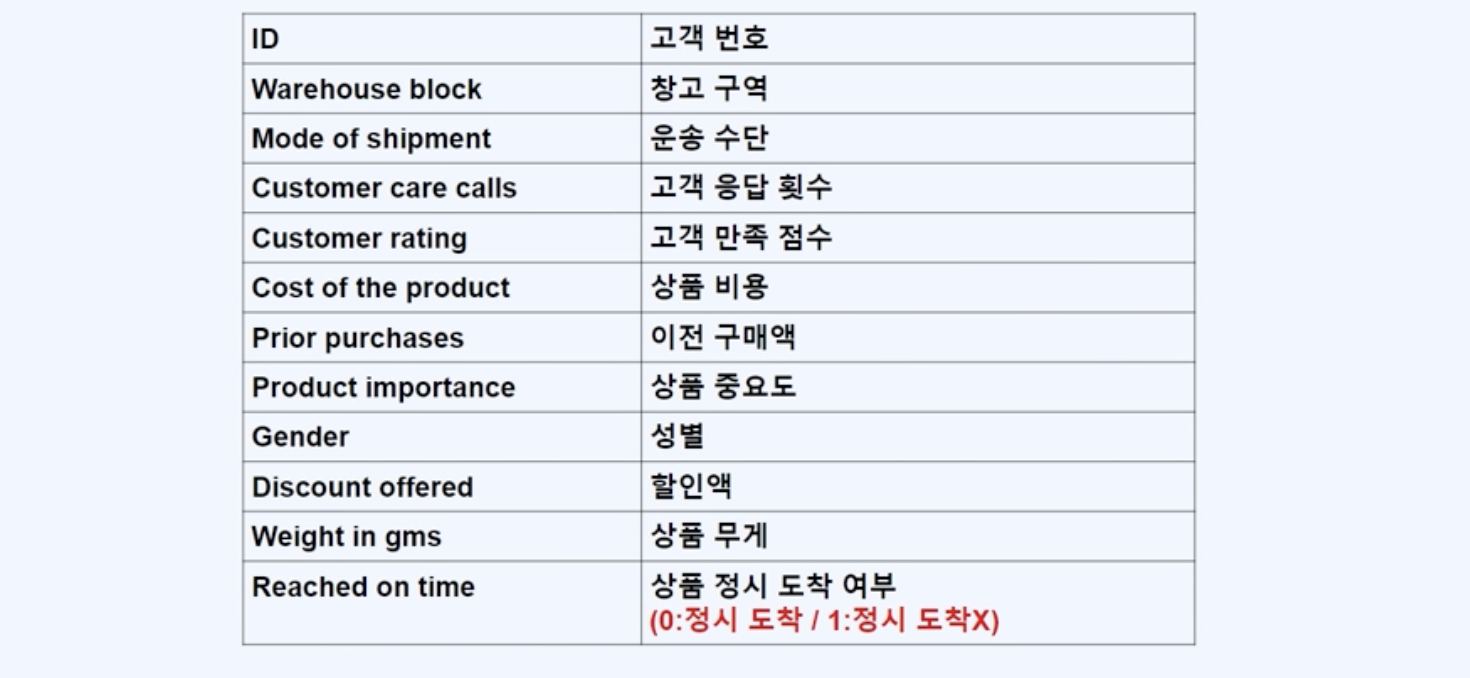

Reached on time 항목을 target 값으로 활용 가능

**분석 목표: 고객 상품 배송 정보를 활용한 정시 배송 예측**  

<진행 내용>  
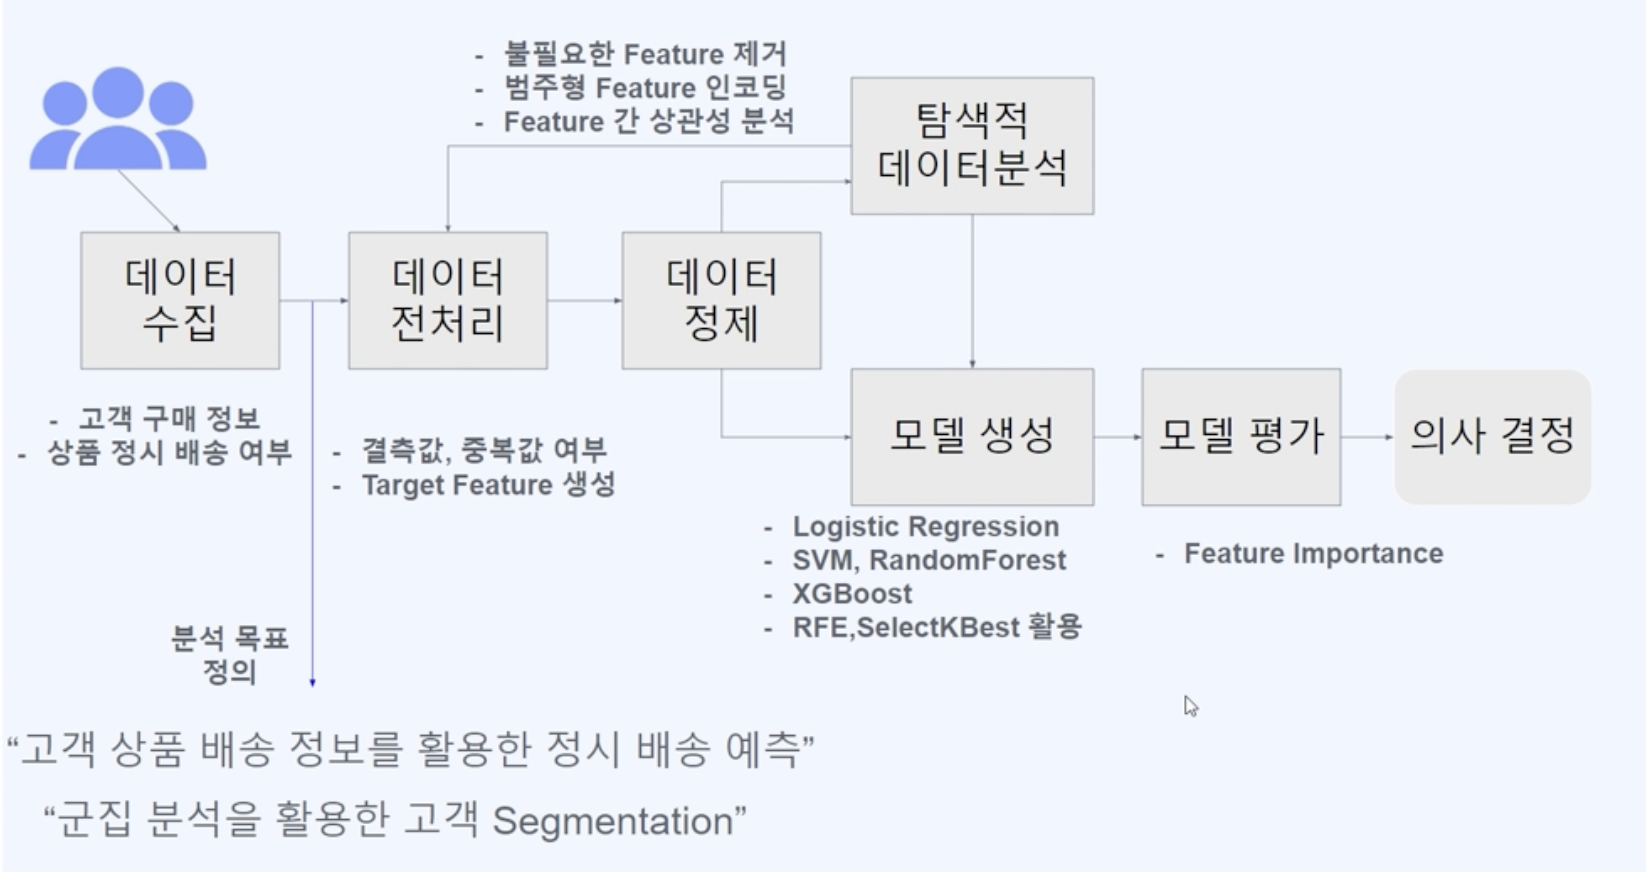